# **Исследование объявлений об аренде квартир. Часть 4. Построение модели. Оценка качества модели**

# Введение

**Задача** - предсказание стоимости аренды квартир — **регрессия**.

В работе рассмотрены следующие модели :

---

- Линейная регрессия
- Случайный лес
- CatBoost
- CatBoost_tuned улучшенный с помощью Optuna.

Использовались следующие метрики:

---

**1. RMSE (Root Mean Squared Error)**
- **Что измеряет:** Среднеквадратичную ошибку. Чувствителен к большим отклонениям.  
- **Почему важен:**  
  - Штрафует модели за крупные ошибки (например, если модель сильно занизит или завысит цену).  
  - Полезен, если критично избежать **катастрофически неточных** предсказаний (например, при оценке рисков).  
- **Недостаток:** Сильно зависит от масштаба данных (в нашем случае значения ~10⁸ говорят о том, что ошибки могут быть большими в абсолютных величинах).  

---

**2. MAE (Mean Absolute Error)**
- **Что измеряет:** Среднюю абсолютную ошибку в исходных единицах (например, в рублях).  
- **Почему важен:**  
  - Легко интерпретировать: «Модель в среднем ошибается на ±9600 рублей».  
  - Менее чувствителен к выбросам, чем RMSE.  
- **Когда использовать:** Если важно понимать **среднюю величину ошибки** без учета экстремальных случаев.  

---

**3. R² (Коэффициент детерминации)**
- **Что измеряет:** Долю дисперсии, объясненную моделью (от 0 до 1, где 1 — идеальное предсказание).  
- **Почему важен:**  
  - Показывает, насколько модель лучше, чем простое предсказание средним значением.  
  - Удобен для сравнения моделей на разных данных.  
- **Ограничение:** Может быть высоким даже при систематических ошибках, если модель хорошо улавливает тенденции.  

---

**4. MAPE (Mean Absolute Percentage Error)**
- **Что измеряет:** Среднюю ошибку в процентах от реальных значений.  
- **Почему важен:**  
  - Дает интуитивно понятную оценку: «Модель ошибается в среднем на 12%».  
  - Незаменим в бизнес-аналитике, где важно понимать **относительную точность**.  
- **Недостаток:** Не работает, если в данных есть нулевые или близкие к нулю значения (для цен аренды такое практически не случается).  

---

**5. Время обучения (TIME)**
- **Что измеряет:** Сколько секунд/минут требуется для обучения модели.  
- **Почему важен:**  
  - Для продакшн-решений скорость может быть критична (например, если модель переобучается ежедневно).  
  - Позволяет оценить компромисс между качеством и вычислительными затратами.  

---

**Бизнес-контекст:**  
   - Арендодателям или сервисам важна **понятность ошибок** (MAPE: «на сколько процентов ошибаемся?»).    

**Скорости:**  
   - Время обучения помогает выбрать модель, которая не только точна, но и практична для развертывания.  

---  

**Итог:** Выбранные метрики покрывают все ключевые аспекты задачи регрессии — точность, интерпретируемость и скорость. CatBoost_tuned выигрывает по большинству из них.

**Краткие выводы:**

- **Лучшая модель: CatBoost_tuned** (максимальное R², минимальные ошибки, разумное время обучения).  
- Если критична скорость, можно использовать обычный **CatBoost** (разница в качестве минимальна).  
- **LinearRegression** можно использовать как baseline, но для серьезных задач он недостаточно точен.  
- **RandomForest** проигрывает CatBoost по всем параметрам.  

**Вывод:** CatBoost (особенно с тюнингом) – лучший выбор для предсказания стоимости аренды квартир в данном сравнении. Хотя для реальных задач процент ошибки 12% все еще довольно высок.

**Импорт библиотек**

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LassoCV
from scipy.stats import randint
from catboost import CatBoostRegressor
import optuna
from optuna.pruners import SuccessiveHalvingPruner

# Предобработка данных

Ниже представлена укороченная версия блока проекта по обработке данных (EDA)

Описание данных

**metro** (text)	-             Ближайшее метро

**walk_to_metro_flg**	(bool)	-	Флаг пешей доступности

**address**	(text)	-	Адрес

**price**	(float8) -	Цена, руб.

**m_sqarea**	(float8)	-	Метраж, кв.м

**floor_flat**	(float8)	-	Этаж

**floor_max**	(float8)	-	Этажность дома

**rooms**	(int8)	-	Количество комнат

**latitude**	(float8) -	Широта

**longitude**	(float8)	-	Долгота

**district_name** (text) - Округ

**dist_to_center**	(float8)	-	Дальность от Кремля

**r_per_meter**	(float8)	-	Рублей за метр

**room_square**	(float8)	-	Средняя площадь комнаты

**Холодильник**	(int8)	-	Наличие	холодильника

**Посудомоечная машина**	(int8)	-	Наличие	посудомоечной машины

**Стиральная машина**	(int8)	-	Наличие	стиральной машины

**Кондиционер**	(int8)	-	Наличие кондиционера

**Телевизор**	(int8)	-	Наличие телевизора

**Интернет**	(int8)	-	Наличие интернета

**Мебель на кухне**	(int8)	-	Наличие мебели на кухне

**Мебель в комнатах**	(int8)	-	Наличие	мебели в комнатах

**Оплата ЖКХ**	(text)	-	Входит ли стоимость в оплату

**Залог**	(int4) -	Сумма, руб.

**Предоплата_месяцев**	(int4)	-	Кол-во месяцев

**Срок аренды**	(text)	-	От года или нет

**С животными**	(bool)	-	Разрешено ли

**С детьми**	(bool)	-	Разрешено ли

**Общая площадь**	(float8)	-	Площадь, кв.м

**Жилая площадь**	(float8)	-	Площадь, кв.м

**Площадь кухни**	(float8)	-	Площадь, кв.

**Санузел**	(text)	-	Тип и кол-во

**Балкон/лоджия**	(text)	-	Тип и кол-во

**Вид из окон**	(text)	-	Куда выходят окна

**Ремонт**	(text)	-	Тип ремонта

**Год постройки**	(float8)	-	Год постройки

**Количество лифтов**	(text)	Дискретная количественная	Тип и кол-во

**Тип перекрытий**	(text)	-	Тип

**Парковка**	(text)	-	  Тип

**Отопление**	(text) -	  Тип

**Аварийность**	(int4)	-	Да или нет

**school_1000m**	(int8)	-	Кол-во школ в радиусе

**shops_200m**	(int8)	-	Кол-во магазинов в радиусе

**theatre_1000m**	(int8)	-	Кол-во театров в радиусе

**fitness_500m**	(int8)	-	Кол-во спортзалов в радиусе

**cinemas_1500m**	(int8)	-	Кол-во кинотеатров в радиусе

**foods_1000m**	(int8)	-	Кол-во точек питания в радиусе

**kindergarten_500m**	(int8)	-	Кол-во детсадов в радиусе	500 м

**libraries_1000m**	(int8)	-	Кол-во библиотек в радиусе 1000 м

**parks_2000m**	(int8)	-	Кол-во парков в радиусе	2000 м

**post_office_1000m**	(int8)	-	Кол-во почт в радиусе	1000 м

**climbing_1000m**	(int8)	-	Кол-во скалодромов в радиусе 1000 м

**fields_1000m**	(int8)	-	Кол-во футб. полей в радиусе 1000 м

**indoor_swimming_pool_1000m**	(int8)	-	Кол-во бассейнов в радиусе

**malls_2000m**	(int8)	-	Кол-во тц в радиусе

**outdoor_swimming_pool_1000m**	(int8)	-	Кол-во открытых бассейнов в радиусе

**is_first_floor**	(bool)	-	Первый этаж

**is_max_floor**	(bool)	-	Последний этаж дома

**Дальнейшие действия**:
1. Проверяем данные на полные дубликаты. Всего **16060** строк.
2. Удаляем полностью строки, в которых не заполнен пул данных в столбцах Общая площадь, Холодильник, Посудомоечная машина, Стиральная машина, Кондиционер, Телевизор, Интернет, Мебель на кухне, Мебель в комнатах, Оплата ЖКХ, Залог, Предоплата_месяцев, Срок аренды (не распарсились из-за ошибки на странице обявления).

   Остается **15116** строк
   
   и 15 столбцов с пропусками:

 -  Аварийность
 -  Количество лифтов
 -  Санузел
 -  district_name
 -  Парковка
 -  Год постройки
 -  С животными
 -  С детьми
 -  Жилая площадь
 -  Площадь кухни
 -  Балкон/лоджия
 -  Вид из окон
 -  Ремонт
 -  Тип перекрытий
 -  Отопление


 3. По указанным 15 столбцам ищу уникальные значения и произвожу замену.
 - '**Аварийность**' - заменяю пропуски на 0 - наиболее популярное значение (аварийных домов из данных всего 1)
 - '**Количество лифтов**' - заменяю на самое популярное значение для данного вида этажности. Ввожу новый признак наличие грузового лифта и сумма лифтов
 - '**Санузел**' - заменяю на самое поплуряное значение для данного вида комнатности. Плюс создаю доп. признаки: сумма санузлов и наличие совмещенного санузла
 - '**district_name**' - всего три пропуска, заменяю их с учетом аббревиатуры округа в адресе
 - '**Парковка**' - пропуски заменяю на 'Наземная', помимо пропусков присутсвуют некорретные названия, которые меняю по смыслу на существующие признаки, например 'ПарковкаНаземная' на 'Наземная' или 'Открытая' на 'Наземная'
 - '**Год постройки**' - заменяю часть пропусков на такой же год, который имеет такой же адрес в других объявлениях. Также удаляею строки, где год построки 2026, т.к. он еще не наступил. Заменяю оставшиеся пропуски наиболее часто встречающимся по районам
 - '**С животными**', '**С детьми**' - ввожу новый признак 'По договоренности'
 - '**Балкон/лоджия**' - пропуски заменяю на новый признак 'нет'. Добавим два дополнительных признака: сумма балконов/лоджий и их наличие да/нет
 - '**Отопление**', '**Тип перекрытий**' - заменяю на существующий признак 'Нет информации'
 - '**post_office_1000m**' - отсутвуют значения, т.е. везде 0, поэтому этот столбец можно удалить
 - '**Ремонт**' - заменяю пропуски на самое популярное значение для данного года постройки
 - '**Площадь кухни**' - создадим дополнительный признак "доля площади кухни к площади квартиры" и заменим пропуски в новом столбце на наиболее популярное значение по году постройки и по комнатности, затем пропуски в ст. "Площадь кухни" заменим на произведение "Общей площади" на "Долю кухни".
 - '**Жилая площадь**' - создадим дополнительный признак "доля общей площади к площади квартиры" и заменим пропуски в новом столбце на наиболее популярное значение по году постройки и по комнатности, затем пропуски в ст. "Жилая площадь" заменим на произведение "Общей площади" на "Долю жилой площади".
 - **Вид из окон** - имеет 13.40% пропусков. Как показал анализ, отличия по цене не сильные, этот столбец можно исключить.

In [ ]:
# Проверим и удалим строки на полные дубликаты
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16060 entries, 0 to 16059
Data columns (total 58 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   metro                        16060 non-null  object 
 1   walk_to_metro_flg            16060 non-null  bool   
 2   address                      16060 non-null  object 
 3   price                        16060 non-null  float64
 4   m_sqarea                     16060 non-null  float64
 5   floor_flat                   16060 non-null  float64
 6   floor_max                    16060 non-null  float64
 7   rooms                        16060 non-null  int64  
 8   latitude                     16060 non-null  float64
 9   longitude                    16060 non-null  float64
 10  district_name                16057 non-null  object 
 11  dist_to_center               16060 non-null  float64
 12  r_per_meter                  16060 non-null  float64
 13  room_square     

In [ ]:
# Удалим строки, где пропущены значения в пуле столбцов. Для этого выберем столбец "Общая площадь"
df = df.dropna(subset=['Общая площадь'])

# Заполним пропуски в столбце "аварийность" наиболее популярным признаком,
# т.к. в данных всего один аварийный объект с нормальной ценой, похоже на ошибку
df.loc[:, 'Аварийность'] = df['Аварийность'].fillna(0)

# Заменим пропуски в "Количество лифтов" наиболее часто встречающимся для каждого типа этажности.
df.loc[:, 'Количество лифтов'] = df['Количество лифтов'].fillna(
    df.groupby('floor_max')['Количество лифтов'].transform(lambda x: x.mode()[0] if not x.mode().empty else "Не указано")
)

In [ ]:
# Функция для подсчета общего количества лифтов
# (вычленение чисел из строк и их сложение)
def count_num(elevator_str):
    if pd.isna(elevator_str):
        return 0
    count = 0
    parts = elevator_str.split(', ')
    for part in parts:
        num = part.split()[0]
        if num.isdigit():
            count += int(num)
    return count

# Функция для определения наличия грузового лифта
def has_freight_elevator(elevator_str):
    if pd.isna(elevator_str):
        return False
    return 'грузовой' in elevator_str or 'грузовых' in elevator_str

# Применяем функции к столбцу
df['сумма_лифтов'] = df['Количество лифтов'].apply(count_num)
df['грузовой_лифт'] = df['Количество лифтов'].apply(has_freight_elevator)

In [ ]:
# Заменим пропуски в "Санузел" наиболее часто встречающимся для каждого типа комнатности.
df['Санузел'] = df['Санузел'].fillna(
    df.groupby('rooms')['Санузел'].transform(lambda x: x.mode()[0] if not x.mode().empty else "Не указано")
);

# Функция для определения наличия раздельного санузла
def has_freight_toilet (str):
    if pd.isna(str):
        return False
    return 'совмещенный' in str or 'совмещенных' in str

# Применяем функции к столбцу
df['сумма_санузлов'] = df['Санузел'].apply(count_num)
df['совмещенный'] = df['Санузел'].apply(has_freight_toilet)

In [ ]:
# Заполнение пропусков в столбце district_name
df.loc[(df['district_name'].isna()) & (df['address'].str.contains('ЮАО')), 'district_name'] = 'Южный административный округ'
df.loc[(df['district_name'].isna()) & (df['address'].str.contains('СЗАО')), 'district_name'] = 'Северо-Западный административный округ'
df.loc[(df['district_name'].isna()) & (df['address'].str.contains('САО')), 'district_name'] = 'Северный административный округ'

In [ ]:
# Заполним пропуски в столбце "Парковка" существующим признаком - Наземная
df['Парковка'] = df['Парковка'].fillna('Наземная');

# Заменим "ПарковкаНаземная" на "Наземная", "ПарковкаПодземная" на "Подземная", "ПарковкаОткрытая" на "Открытая"
df['Парковка'] = df['Парковка'].replace({'ПарковкаНаземная': 'Наземная', \
                                         'ПарковкаПодземная': 'Подземная', \
                                         'ПарковкаОткрытая': 'Наземная', \
                                         'ПарковкаМногоуровневая': 'Многоуровневая',
                                         'Открытая': 'Наземная',});

In [ ]:
# Удалим строку (она одна) с годом построки 2026 г, т.к. он еще не наступил
df = df[df['Год постройки'] != 2026]

# Заполним пропуски в "Год_постройки" для каждого адреса
# (вставим в пустые строки год постройки по схожему адресу)
df["Год постройки"] = df.groupby("address")["Год постройки"] \
                        .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'));

# Заменим пропуски для "Год постройки" на наиболее часто встречающийся в этом районе
df['Год постройки'] = df['Год постройки'].fillna(
    df.groupby('district_name')['Год постройки'].transform(lambda x: x.mode()[0] if not x.mode().empty else "Не указано")
);

<ipython-input-147-767948236>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'));


In [ ]:
# Заполним пропуски в столбце "С животными" новым признаком - По договоренности
df['С животными'] = df['С животными'].fillna('по договоренности');

# Заполним пропуски в столбце "С детьми" новым признаком - По договоренности
df['С детьми'] = df['С детьми'].fillna('по договоренности');

# обработаем пропуски в балконах/лоджиях, заменим их на
df['Балкон/лоджия'] = df['Балкон/лоджия'].fillna('нет');

In [ ]:
# Функция для определения наличия грузового лифта
def has_freight_balkon(str):
    if pd.isna(str):
        return False
    return 'балкон' in str or 'балкона' in str or 'лоджия' in str or 'лоджии' in str

# Применяем функции к столбцу
df['сумма_балконов'] = df['Балкон/лоджия'].apply(count_num)
df['балкон'] = df['Балкон/лоджия'].apply(has_freight_balkon)

In [ ]:
# Заполним пропуски в столбце "Отопление" существующим признаком - Нет информации
df['Отопление'] = df['Отопление'].fillna('Нет информации');

# Заполним пропуски в столбце "Тип перекрытий" существующим признаком - Нет информации
df['Тип перекрытий'] = df['Тип перекрытий'].fillna('Нет информации');

# Заменим пропуски для "Ремонт" на наиболее популярный "Евроремонт"
df['Ремонт'] = df['Ремонт'].fillna('Евроремонт');

# Площадь кухни
df['Доля площади кухни'] = df['Площадь кухни'] / df['Общая площадь']

# Заменяем пропуски в 'Доля площади кухни' на медианное значение по комнатности и году постройки
df['Доля площади кухни'] = df.groupby(['Год постройки', 'rooms'])['Доля площади кухни'].transform(np.median);

# Замена пропусков в столбце "Площадь кухни"
df['Площадь кухни'] = df['Площадь кухни'].fillna(df['Доля площади кухни'] * df['Общая площадь'])

# Заполняем пропуски средними значениями для каждой комнатности
df['Доля площади кухни'] = df.groupby('rooms')['Доля площади кухни'].transform(lambda x: x.fillna(x.mean()))

# Замена пропусков в столбце "Площадь кухни"
df['Площадь кухни'] = df['Площадь кухни'].fillna(df['Доля площади кухни'] * df['Общая площадь'])

df['Доля жилой площади'] = df['Жилая площадь'] / df['Общая площадь']

# Заменяем пропуски в 'Доля площади кухни' на медианное значение по комнатности и году постройки
df['Доля жилой площади'] = df.groupby(['Год постройки', 'rooms'])['Доля жилой площади'].transform(np.median);

In [ ]:
# Замена пропусков в столбце "Площадь кухни"
df['Жилая площадь'] = df['Жилая площадь'].fillna(df['Доля жилой площади'] * df['Общая площадь'])

# Заполняем пропуски средними значениями для каждой комнатности
df['Доля жилой площади'] = df.groupby('rooms')['Доля жилой площади'].transform(lambda x: x.fillna(x.mean()))

# Замена пропусков в столбце "Площадь кухни"
df['Жилая площадь'] = df['Жилая площадь'].fillna(df['Доля жилой площади'] * df['Общая площадь'])

In [ ]:
# Вычисляем IQR
Q1 = df["Общая площадь"].quantile(0.25)  # Первый квартиль (25%)
Q3 = df["Общая площадь"].quantile(0.75)  # Третий квартиль (75%)
IQR = Q3 - Q1  # Межквартильный размах

# Границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем данные без выбросов
df_square = df[(df["Общая площадь"] >= lower_bound) & (df["Общая площадь"] <= upper_bound)]

In [ ]:
# Вычисляем IQR
Q1 = df_square["r_per_meter"].quantile(0.25)  # Первый квартиль (25%)
Q3 = df_square["r_per_meter"].quantile(0.75)  # Третий квартиль (75%)
IQR = Q3 - Q1  # Межквартильный размах

# Границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем данные без выбросов
df_r = df_square[(df["r_per_meter"] >= lower_bound) & (df_square["r_per_meter"] <= upper_bound)]

In [ ]:
# Вычисляем IQR
Q1 = df_r["Общая площадь"].quantile(0.25)  # Первый квартиль (25%)
Q3 = df_r["Общая площадь"].quantile(0.75)  # Третий квартиль (75%)
IQR = Q3 - Q1  # Межквартильный размах

# Границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем данные без выбросов
df_rmp = df_r[(df_r["Общая площадь"] >= lower_bound) & (df_r["Общая площадь"] <= upper_bound)]

In [ ]:
# Удаление выбросов по площади кухни
# Вычисляем IQR
Q1 = df_rmp["Площадь кухни"].quantile(0.25)  # Первый квартиль (25%)
Q3 = df_rmp["Площадь кухни"].quantile(0.75)  # Третий квартиль (75%)
IQR = Q3 - Q1  # Межквартильный размах

# Границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем данные без выбросов
df_clean = df_rmp[(df_rmp["Площадь кухни"] >= lower_bound) & (df_rmp["Площадь кухни"] <= upper_bound)]

In [ ]:
df_clean['park'] = df_clean['parks_2000m'] > 0
df_clean['school'] = df_clean['school_1000m'] > 0
df_clean['shops'] = df_clean['shops_200m'] > 0
df_clean['theatre'] = df_clean['theatre_1000m'] > 0
df_clean['fitness'] = df_clean['fitness_500m'] > 0
df_clean['cinemas'] = df_clean['cinemas_1500m'] > 0
df_clean['foods'] = df_clean['foods_1000m'] > 0
df_clean['kindergarten'] = df_clean['kindergarten_500m'] > 0
df_clean['libraries'] = df_clean['libraries_1000m'] > 0
df_clean['climbing'] = df_clean['climbing_1000m'] > 0
df_clean['fields'] = df_clean['fields_1000m'] > 0
df_clean['outdoor_swimming_pool'] = df_clean['outdoor_swimming_pool_1000m'] > 0
df_clean['indoor_swimming_pool'] = df_clean['indoor_swimming_pool_1000m'] > 0
df_clean['malls'] = df_clean['malls_2000m'] > 0

In [ ]:
# Обработка данных по залогу
df_clean.loc[df['Залог'] > 1000000, 'Залог'] = 110000

# Заменим сумму залога в руб. на кол-во месяцев
df_clean['Залог'] = df_clean['Залог'] / df_clean['price']

In [ ]:
# Обработка данных по кол-ву лифтов
df_clean['сумма_лифтов'] = df['сумма_лифтов'].replace(12, 2);
df_clean.loc[df['сумма_лифтов'] >= 5, 'сумма_лифтов'] = '5 лифтов и более'

# Преобразуем все значения в строки
df_clean['сумма_лифтов'] = df_clean['сумма_лифтов'].astype(str)

# Округляем расстояние до 1 км
df_clean['distance_rounded'] = np.round(df_clean['dist_to_center']);

In [ ]:
# Удаление выбросов по цене по районам и комнатности
def remove_outliers_by_rooms_and_district(df, column='price'):
    df_clean = df.copy()
    for (rooms, district), subset in df_clean.groupby(['rooms', 'district_name']):
        Q1 = subset[column].quantile(0.25)
        Q3 = subset[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[
            ~((df_clean['rooms'] == rooms) &
                (df_clean['district_name'] == district) &
                ((df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)))]
    final_len = len(df_clean)
    return df_clean

df_clean = remove_outliers_by_rooms_and_district(df_clean, column='price')

In [ ]:
# Исключаем дублирующие признаки
df_clean = df_clean.drop(columns=["metro", "latitude", "longitude", "address",
                                  "r_per_meter", "Залог", "Предоплата_месяцев", "Общая площадь",
                                  "Жилая площадь", "distance_rounded",
                                  "Аварийность", "Количество лифтов", "Санузел", "Балкон/лоджия",
                                  "Вид из окон", "Доля площади кухни", "Доля жилой площади"])

# Итоговый датасет для работы

In [5]:
df = pd.read_csv('/content/data_clean.csv')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12409 entries, 0 to 12408
Data columns (total 64 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   walk_to_metro_flg            12409 non-null  bool   
 1   price                        12409 non-null  float64
 2   m_sqarea                     12409 non-null  float64
 3   floor_flat                   12409 non-null  float64
 4   floor_max                    12409 non-null  float64
 5   rooms                        12409 non-null  int64  
 6   district_name                12409 non-null  object 
 7   dist_to_center               12409 non-null  float64
 8   room_square                  12409 non-null  float64
 9   Холодильник                  12409 non-null  float64
 10  Посудомоечная машина         12409 non-null  float64
 11  Стиральная машина            12409 non-null  float64
 12  Кондиционер                  12409 non-null  float64
 13  Телевизор       

In [ ]:
df.head()

,walk_to_metro_flg,price,m_sqarea,floor_flat,floor_max,rooms,district_name,dist_to_center,room_square,Холодильник,Посудомоечная машина,Стиральная машина,Кондиционер,Телевизор,Интернет,Мебель на кухне,Мебель в комнатах,Оплата ЖКХ,Срок аренды,С животными,С детьми,Площадь кухни,Ремонт,Год постройки,Тип перекрытий,Парковка,Отопление,school_1000m,shops_200m,theatre_1000m,fitness_500m,cinemas_1500m,foods_1000m,kindergarten_500m,libraries_1000m,parks_2000m,post_office_1000m,climbing_1000m,fields_1000m,indoor_swimming_pool_1000m,malls_2000m,outdoor_swimming_pool_1000m,is_first_floor,is_max_floor,сумма_лифтов,грузовой_лифт,сумма_санузлов,совмещенный,сумма_балконов,балкон,park,school,shops,theatre,fitness,cinemas,foods,kindergarten,libraries,climbing,fields,outdoor_swimming_pool,indoor_swimming_pool,malls
0,False,55000.0,35.4,2.0,9.0,1,Восточный административный округ,12.0,35.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,включены в сумму,несколько месяцев,False,True,10.0,Косметический,1968.0,Железобетонные,Наземная,Центральное,19,1,1,0,0,80,2,2,12,0,0,0,0,22,0,False,False,1,False,1,True,0,False,True,True,True,True,False,False,True,True,True,False,False,False,False,True
1,False,55000.0,42.0,9.0,16.0,2,Троицкий административный округ,34.0,21.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,счетчики отдельно,от года,False,True,16.0,Евроремонт,2022.0,Железобетонные,Наземная,Индивидуальный тепловой пункт,0,6,0,0,0,3,0,0,2,0,0,0,0,0,0,False,False,2,True,1,True,1,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False
2,False,50000.0,41.8,5.0,13.0,1,Троицкий административный округ,34.0,41.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,счетчики отдельно,от года,по договоренности,по договоренности,10.0,Дизайнерский,2022.0,Железобетонные,Наземная,Индивидуальный тепловой пункт,0,4,0,0,0,3,0,0,2,0,0,0,0,0,0,False,False,2,True,1,True,1,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False
3,False,40000.0,40.0,11.0,14.0,1,Троицкий административный округ,34.0,40.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,счетчики отдельно,от года,по договоренности,по договоренности,10.0,Косметический,2022.0,Железобетонные,Наземная,Индивидуальный тепловой пункт,0,4,0,0,0,3,0,0,1,0,0,0,0,0,0,False,False,2,True,1,True,1,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False
4,False,45000.0,42.0,13.0,14.0,1,Троицкий административный округ,34.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,счетчики отдельно,от года,по договоренности,по договоренности,7.0,Косметический,2022.0,Железобетонные,Наземная,Индивидуальный тепловой пункт,0,4,0,0,0,3,0,0,1,0,0,0,0,0,0,False,False,2,True,1,True,1,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False


# Разбивка на тренировочную и тестовую выборки

In [6]:
# Определение таргет и фичей
X = df.drop('price', axis=1)
y = df['price']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Построение моделей

## 1. Модель линейной регрессии

In [7]:
cat_features = [
    'district_name', 'Оплата ЖКХ', 'Срок аренды', 'С животными', 'С детьми',
    'Ремонт', 'Тип перекрытий', 'Парковка', 'Отопление', 'сумма_лифтов'
]

In [10]:
# кодирование категориальных признаков
encoder = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [11]:
# Применяем StandardScaler для масштабирования признаков
# Для линейной модели отмасштабируем булевые признаки тоже
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [12]:
# Обучение
start_time = time.time()
model = LinearRegression()
model.fit(X_train_scaled, y_train)

end_time = time.time()
training_time_lin = end_time - start_time
print(f"Время обучения: {training_time_lin:.2f} секунд")

# Предсказания
y_pred = model.predict(X_test_scaled)

# Метрики
rmse_lin = mean_squared_error(y_test, y_pred)
mae_lin = mean_absolute_error(y_test, y_pred)
r2_lin = r2_score(y_test, y_pred)
mape_lin = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"R²: {r2_lin:.4f}")
print(f"MAE: {mae_lin:.1f}")
print(f"RMSE: {rmse_lin:.1f}")
print(f"MAPE: {mape_lin:.2f}%")

Время обучения: 0.44 секунд
R²: 0.7614
MAE: 12280.1
RMSE: 297667152.1
MAPE: 15.32%


In [21]:
# Получаем имена категориальных признаков после OneHotEncoder
cat_encoder = encoder.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(cat_features)

# Получаем имена всех остальных (некатегориальных) признаков
remaining_features = [col for col in X_train.columns if col not in cat_features]

# Объединяем имена всех признаков
all_feature_names = np.concatenate([cat_feature_names, remaining_features])

# Создаем DataFrame с коэффициентами
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

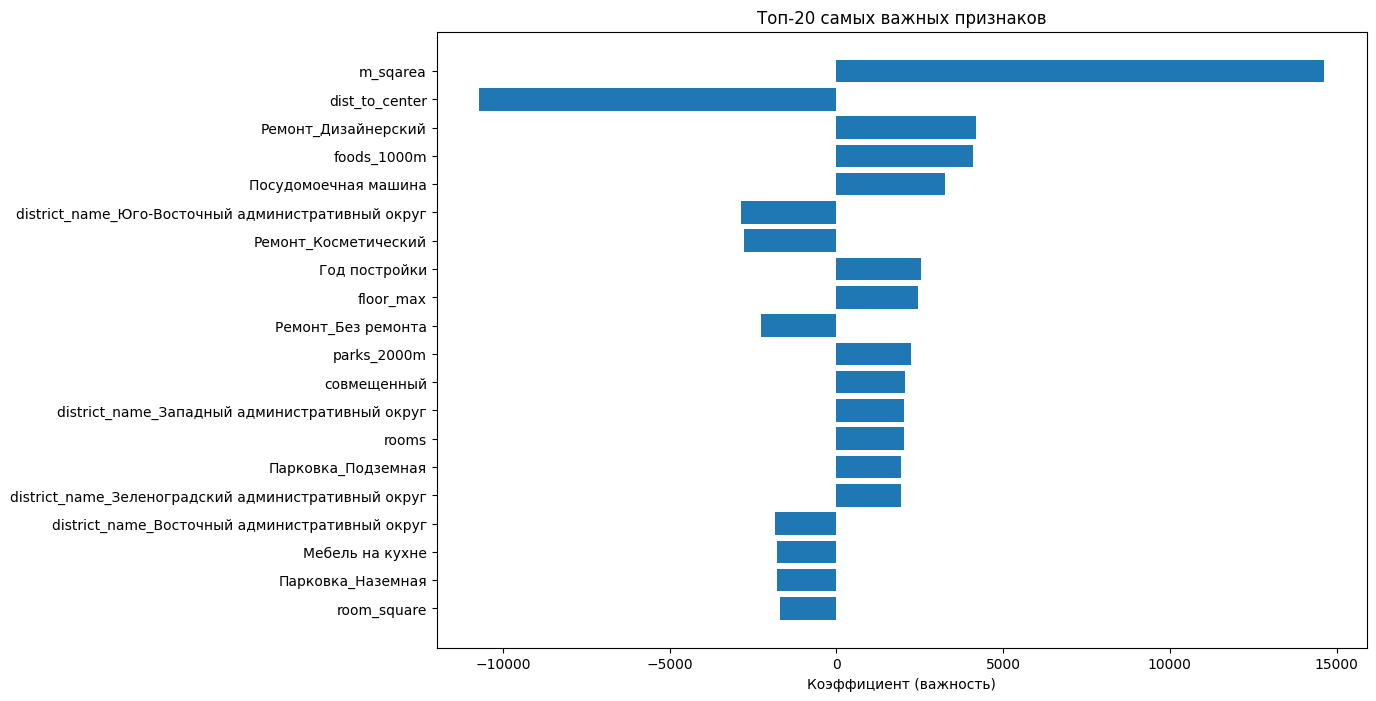

In [20]:
plt.figure(figsize=(12, 8))
top_features = coef_df.head(20)
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Коэффициент (важность)')
plt.title('Топ-20 самых важных признаков')
plt.gca().invert_yaxis()  # Чтобы самый важный признак был сверху
plt.show()

## 2. Модель регрессии Случайный лес

Построим модель с использованием pipline для примера, что так тоже можно

In [ ]:
# Выделим признаки
numerical_cols = X.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

# Препроцессинг
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Пайплайн
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor), #кодировка
#    ('feature_selection', SelectFromModel(LassoCV(cv=5, random_state=42))), #отброс лишних параметров
    ('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)) #модель
])

start_time = time.time()
# Обучение
pipeline.fit(X_train, y_train)

end_time = time.time()
training_time_forest = end_time - start_time
print(f"Время обучения: {training_time_forest:.2f} секунд")

# Предсказания
y_pred = pipeline.predict(X_test)

# Метрики
rmse_forest = mean_squared_error(y_test, y_pred)
mae_forest = mean_absolute_error(y_test, y_pred)
r2_forest = r2_score(y_test, y_pred)
mape_forest = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"R²: {r2_forest:.4f}")
print(f"MAE: {mae_forest:.1f}")
print(f"RMSE: {rmse_forest:.1f}")
print(f"MAPE: {mape_forest:.2f}%")

Время обучения: 27.54 секунд
R²: 0.8119
MAE: 10622.8
RMSE: 234705953.4
MAPE: 13.16%


In [ ]:
# Параметры для поиска
param_distributions = {
    'model__n_estimators': randint(100, 300),
    'model__max_depth': [10, 20, 30, None],
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5),
    'model__max_features': ['auto', 'sqrt', 'log2']
}

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Запуск
search.fit(X_train, y_train)

# Лучшие параметры и результат
print("Лучшие параметры:", search.best_params_)
print(f"Лучшая RMSE (на CV): {-search.best_score_:.2f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
21 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

Лучшие параметры: {'model__max_depth': 30, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 3, 'model__n_estimators': 187}
Лучшая RMSE (на CV): 15508.42


In [ ]:
# Пайплайн
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor), #кодировка
#    ('feature_selection', SelectFromModel(LassoCV(cv=5, random_state=42))), #отброс лишних параметров
    ('model', RandomForestRegressor(max_depth=30, min_samples_leaf=1, n_estimators=187, random_state=42, n_jobs=-1)) #модель
])

start_time = time.time()
# Обучение
pipeline.fit(X_train, y_train)

end_time = time.time()
training_time_forest = end_time - start_time
print(f"Время обучения: {training_time_forest:.2f} секунд")

# Предсказания
y_pred = pipeline.predict(X_test)

# Метрики
rmse_forest = mean_squared_error(y_test, y_pred)
mae_forest = mean_absolute_error(y_test, y_pred)
r2_forest = r2_score(y_test, y_pred)
mape_forest = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"R²: {r2_forest:.4f}")
print(f"MAE: {mae_forest:.2f}")
print(f"RMSE: {rmse_forest:.2f}")
print(f"MAPE: {mape_forest:.2f}%")

Время обучения: 28.68 секунд
R²: 0.8103
MAE: 10666.81
RMSE: 236684339.47
MAPE: 13.22%


## 3. Построение модели CatBoost

Для использования модели CatBoost не требуется вручную стандартизировать числовые признаки или кодировать категориальные object-столбцы, потому что:

Он автоматически обрабатывает категориальные признаки — в том числе object, bool, int, если мы передадим их в список cat_features.

Стандартизация (масштабирование) числовых признаков не нужна, т.к. CatBoost — это бустинг над деревьями, а не линейная модель.

Подберем параметры вручную

In [ ]:
start_time = time.time()

model = CatBoostRegressor(
    random_state=42,
    iterations=500,
    learning_rate=0.1,
    depth=6,
    cat_features=cat_features,
    verbose=100
)
model.fit(X_train, y_train)

end_time = time.time()
training_time_cat = end_time - start_time
print(f"Время обучения: {training_time_cat:.2f} секунд")

y_pred = model.predict(X_test)

# Метрики
rmse_cat = mean_squared_error(y_test, y_pred)
mae_cat = mean_absolute_error(y_test, y_pred)
r2_cat = r2_score(y_test, y_pred)
mape_cat = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"R²: {r2_cat:.4f}")
print(f"MAE: {mae_cat:.2f}")
print(f"RMSE: {rmse_cat:.2f}")
print(f"MAPE: {mape_cat:.2f}%")

0:	learn: 33266.2144327	total: 62.5ms	remaining: 31.2s
100:	learn: 13310.5177670	total: 5.59s	remaining: 22.1s
200:	learn: 12206.2802917	total: 8.76s	remaining: 13s
300:	learn: 11457.5095884	total: 11.6s	remaining: 7.64s
400:	learn: 10849.5285047	total: 13.8s	remaining: 3.42s
499:	learn: 10311.9800457	total: 16.1s	remaining: 0us
Время обучения: 16.34 секунд
R²: 0.8461
MAE: 9705.94
RMSE: 191996670.38
MAPE: 11.83%


In [ ]:
# Сравним с предсказаниями на Трейн, чтобы исключить переобучение
#pred = model.predict(X_train)
#print(f'R²: {r2_score(y_train, pred):.4f}')
#print(f'MAE: {mean_absolute_error(y_train, y_pred):.1f}')

In [ ]:
# Функция для оптимизации
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10),
        'cat_features': cat_features,
        'random_state': 42,
        'verbose': False
    }

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

In [ ]:
# Настройка Pruner
pruner = SuccessiveHalvingPruner(
    min_resource=35,
    reduction_factor=3,
    min_early_stopping_rate=20
)

study = optuna.create_study(
    direction='maximize',
    pruner=pruner
)
study.optimize(objective, n_trials=10)

[I 2025-06-12 07:46:53,009] A new study created in memory with name: no-name-a3607810-2560-4c36-b151-c7889ee66aef
[I 2025-06-12 07:47:08,821] Trial 0 finished with value: 0.8434370480658512 and parameters: {'iterations': 306, 'depth': 8, 'learning_rate': 0.21461439162980983, 'l2_leaf_reg': 9.59481104287277}. Best is trial 0 with value: 0.8434370480658512.
[I 2025-06-12 07:47:13,291] Trial 1 finished with value: 0.821634482093082 and parameters: {'iterations': 338, 'depth': 4, 'learning_rate': 0.049009747490760064, 'l2_leaf_reg': 9.186382849210087}. Best is trial 0 with value: 0.8434370480658512.
[I 2025-06-12 07:47:17,750] Trial 2 finished with value: 0.8157717466759709 and parameters: {'iterations': 336, 'depth': 4, 'learning_rate': 0.031565844598823674, 'l2_leaf_reg': 9.26703855040685}. Best is trial 0 with value: 0.8434370480658512.
[I 2025-06-12 07:47:18,619] Trial 3 finished with value: 0.810377484562929 and parameters: {'iterations': 167, 'depth': 3, 'learning_rate': 0.0836873408

In [ ]:
print('Лучшие параметры:', study.best_params)
print('Лучший R2:', study.best_value)
print(f'Trials завершено: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}/35')
print(f'Trials отсечено: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}')

Лучшие параметры: {'iterations': 491, 'depth': 7, 'learning_rate': 0.09291694301262142, 'l2_leaf_reg': 0.3981267251040498}
Лучший R2: 0.8494965487379978
Trials завершено: 10/35
Trials отсечено: 0


In [23]:
start_time = time.time()

#Обучение финальной модели
best_model = CatBoostRegressor(
    random_state=42,
    iterations=491,
    learning_rate=0.09291694301262142,
    depth=6,
    l2_leaf_reg=0.3981267251040498,
    cat_features=cat_features,
    early_stopping_rounds=20,
    verbose=False
)
best_model.fit(X_train, y_train)

end_time = time.time()
training_time_cat_new = end_time - start_time
print(f"Время обучения: {training_time_cat_new:.2f} секунд")

# Оценка
y_pred = best_model.predict(X_test)
# Добавим округление, т.к. в основном цену округляются до 10000
#y_pred = np.round(y_pred/1000) * 1000

# Метрики
rmse_cat_new = mean_squared_error(y_test, y_pred)
mae_cat_new = mean_absolute_error(y_test, y_pred)
r2_cat_new = r2_score(y_test, y_pred)
mape_cat_new = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"R²: {r2_cat_new:.4f}")
print(f"MAE: {mae_cat_new:.2f}")
print(f"RMSE: {rmse_cat_new:.2f}")
print(f"MAPE: {mape_cat_new:.2f}%")

Время обучения: 30.93 секунд
R²: 0.8488
MAE: 9603.28
RMSE: 188670664.38
MAPE: 11.73%


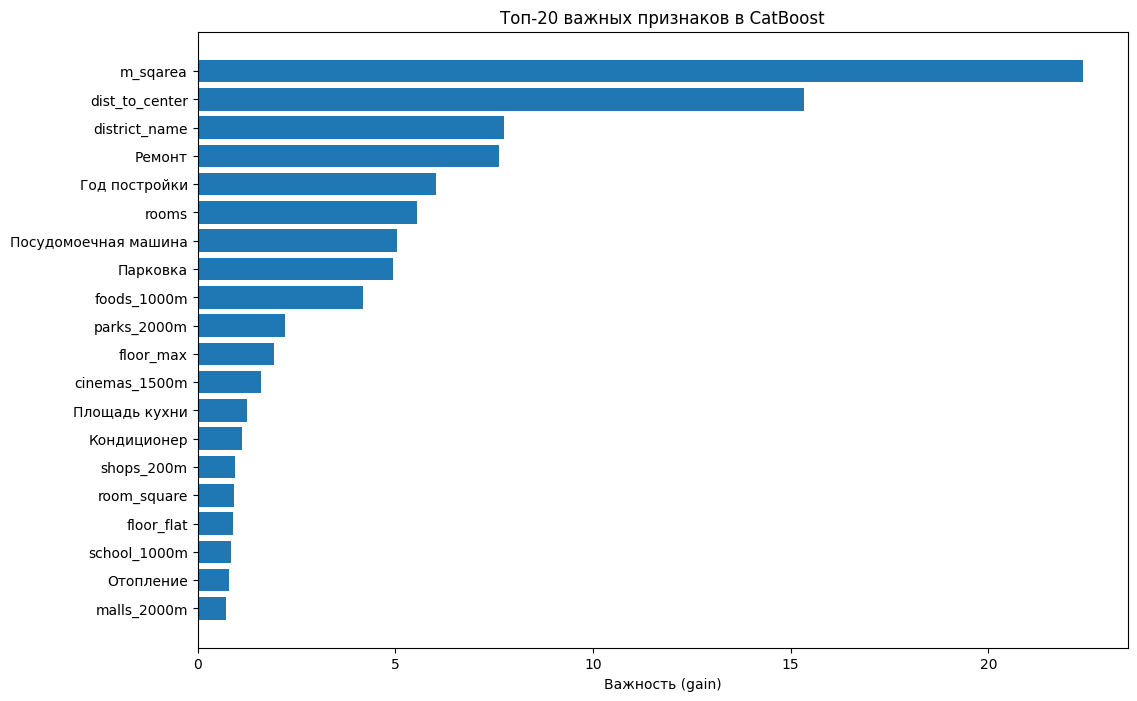

In [24]:
feature_importance = best_model.get_feature_importance()
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Важность (gain)')
plt.title('Топ-20 важных признаков в CatBoost')
plt.gca().invert_yaxis()  # Самый важный признак сверху
plt.show()

# Сравнение моделей

In [ ]:
# Метрики моделей
metrics = {
    'Model': ['LinearRegression', 'RandomForest', 'CatBoost', 'CatBoost_tuned'],
    'RMSE': [rmse_lin, rmse_forest, rmse_cat, rmse_cat_new],
    'MAE': [mae_lin, mae_forest, mae_cat, mae_cat_new],
    'R2': [r2_lin, r2_forest, r2_cat, r2_cat_new],
    'MAPE': [mape_lin, mape_forest, mape_cat, mape_cat_new],
    'TIME': [training_time_lin, training_time_forest, training_time_cat, training_time_cat_new]
}

# Создание DataFrame
metrics_df = pd.DataFrame(metrics)

# Опционально: округлить значения
metrics_df = metrics_df.round(3)

metrics_df

,Model,RMSE,MAE,R2,MAPE,TIME
0,LinearRegression,2.976672e+08,12280.091,0.761,15.325,0.078
1,RandomForest,2.366843e+08,10666.807,0.810,13.216,28.682
2,CatBoost,1.919967e+08,9705.936,0.846,11.834,16.344
3,CatBoost_tuned,1.886707e+08,9603.283,0.849,11.735,13.341


# **Выводы**

Исходя из полученных метрик, можно сделать следующие выводы о моделях, предсказывающих стоимость аренды квартир:

1. **Общее качество моделей**  
   - Все модели демонстрируют достаточно высокое качество предсказаний (**R² > 0.76**), что означает, что они объясняют значительную долю дисперсии в данных.  
   - **CatBoost_tuned** показывает наилучший результат (**R² = 0.849**), немного опережая обычный CatBoost (**R² = 0.846**).  

2. **Точность предсказаний (RMSE, MAE, MAPE)**  
   - **LinearRegression** хуже всех справляется с предсказаниями (наибольшие RMSE, MAE и MAPE).  
   - **RandomForest** улучшает показатели, но уступает CatBoost.  
   - **CatBoost и CatBoost_tuned** дают наименьшие ошибки:  
     - **MAPE ≈ 11.7-11.8%** – это означает, что в среднем модель ошибается на ~12% от реальной цены.  
     - **MAE ≈ 9600-9700** – средняя абсолютная ошибка в денежных единицах.  

3. **Скорость работы (TIME)**  
   - **LinearRegression** обучается быстрее всех (**0.078 сек**), но это компенсируется худшим качеством.  
   - **RandomForest** требует больше всего времени (**28.682 сек**), что может быть критично при работе с большими данными.  
   - **CatBoost** работает быстрее RandomForest (**16.344 сек**), а **CatBoost_tuned** ещё немного оптимизирован по времени (**13.341 сек**).  

4. **Эффективность тюнинга CatBoost**  
   - Тюнинг гиперпараметров CatBoost дал небольшое улучшение:  
     - RMSE снизился с **1.919e+08 → 1.886e+08**,  
     - MAE уменьшился с **9705 → 9603**,  
     - Время работы сократилось с **16.344 → 13.341 сек**.  

**Рекомендации**  
- **Лучшая модель: CatBoost_tuned** (максимальное R², минимальные ошибки, разумное время обучения).  
- Если критична скорость, можно использовать обычный **CatBoost** (разница в качестве минимальна).  
- **LinearRegression** можно использовать как baseline, но для серьезных задач он недостаточно точен.  
- **RandomForest** проигрывает CatBoost по всем параметрам.  

**Вывод:** CatBoost (особенно с тюнингом) – лучший выбор для предсказания стоимости аренды квартир в данном сравнении. Хотя для реальных задач процент ошибки все еще довольно высок.